In [178]:
# This project was created by Eshaank Joshi, Tarunjeev Junja, Trevor Noble, and Evan Vulliamy
# The purpose of this project is to assist United Way
# in the location of areas in need of after school programs in British Columbia.
# The code first selects the rows of the Environics data that correspond to the desired geographical 
# regions and province.
# Next, the data is scaled by relevant population sizes to allow for comparison between different geographical regions.
# The scaled data is then clustered based on correlation scores between each variables. 
# Only one variable is to be selected from each cluster.
# Once the variables are selected then a score for demand is produced by grouping the data 
# into deciles and weights are applied.
# Another score is produced for the amount of supply in each region which is based on the number of available 
# childcare services in each region.
# The difference is taken between supply and demand to quantify the amount of need.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import seaborn as sns
import scipy.cluster.hierarchy as spc
import pandas_bokeh
import pyproj
import geopandas as gpd
from sklearn.cluster import AgglomerativeClustering, KMeans
from collections import Counter
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable


pd.options.mode.chained_assignment = None  # default='warn'

In [179]:
# CHANGE THESE TO YOUR PATHS

bc_ccare_path = "~/Desktop/code/Math402W/402DATA/childcare_locations.csv"
environics_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/EnvironicsData/DemoStats_2020_SelectVarsData.csv"
so_locations_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_map.csv"
so_data_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_DirectMetrics.csv"
shape_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/GeoData/BoundaryShapeFiles"
postal_da_path = r"/Users/evanvulliamy/Desktop/code/Math402W/402DATA/dataverse_files/Data/pccfNat_fccpNat_082021.txt"


In [180]:
# Create the dataframes based on the paths

bc_ccare_df = pd.read_csv(bc_ccare_path)
environics_df = pd.read_csv(environics_path)
so_locations_df = pd.read_csv(so_locations_path)
so_data_df = pd.read_csv(so_data_path)


In [181]:
# Returns the first two digits of the area code which corresponds to the province
def get_province(val):
    return str(val)[0:2]

# Returns the second to fourth digits which corresponds to the census area
def get_census_area(val):
    return str(val)[2:4]

# Adds a space to format postal codes xxxxxx -> xxx xxx
def add_space(string):
    if len(string) >= 7:
        return string
    return string[0:3] + " " + string[3:6]

# Raise all characters to upper case
def to_upper(string):
    return string.upper()

# Separate a string by commas
def split_fn(string):
    return string.split(',')

# Returns the last word in a sentence
def get_last_word(val):
    arr = val.split(" ")
    return arr[-1].isnumeric()

# Returns x normalized in the [0, 1] range where inputs scores get higher outputs
def normalize(x, maximum, minimum):
    return 1 - ((x - minimum) / (maximum - minimum))

In [182]:
# Variables

total_area = "ECYASQKM" # DROP
total_land_area = "ECYALSQKM" # DROP 
total_pop_1 = "ECYBASPOP" # SCALAR
total_pop_2 = "ECYPTAPOP" # SCALAR
total_5_9 = "ECYPTA_5_9" # NEEDS SCALING total_pop_1
total_10_14 = "ECYPTA1014" # DROP
total_60_64 = "ECYPTA6064" # DROP
total_65_69 = "ECYPTA6569" # DROP
total_70_74 = "ECYPTA7074" # DROP
total_75_79 = "ECYPTA7579" # DROP
total_80_84 = "ECYPTA8084" # DROP
total_85_plus = "ECYPTA85P" # DROP
total_fam_households = "ECYHTYFHT" # SCALAR <- should we use this one over census families??
total_65_alone = "ECYHTYN65A" # DROP

census_families = "ECYCFSCF" # SCALAR
cf_with_children = "ECYCFSCWC" # NEEDS SCALING census_families
lone_parent = "ECYCFSLP" # NEEDS SCALING census_families
lp_one_child = "ECYCFSLP1C" # NEEDS SCALING census_families
lp_two_child = "ECYCFSLP2C" # NEEDS SCALING census_families
lp_three_more_child = "ECYCFSLP3C" # NEEDS SCALING census_families
percent_children_home = "ECYHFSWC" # KEEP AS IS
total_kids_home = "ECYCHAKIDS" # SCALAR
kids_home_5_9 = "ECYCHA_5_9" # NEEDS SCALING total_kids_home
kids_home_10_14 = "ECYCHA1014" # DROP
avg_child_per_fam = "ECYCHACFCH" # KEEP AS IS


house_pop_5_year_mobility = "ECYMOBHPOP" # DROP
movers = "ECYMOBMOV" # DROP
household_tenure = "ECYTENHHD" # DROP
rented = "ECYTENRENT" # DROP
band_housing = "ECYTENBAND" # DROP
total_condo_status = "ECYCDOHHD" # DROP
in_condo = "ECYCDOCO" # DROP
rented_in_condo = "ECYCDORECO" # DROP

total_households = "ECYHNIHHD" # SCALAR
income_0_19 = "ECYHNI_020" # ADD WITH income_20_39 NEEDS SCALING total_households
income_20_39 = "ECYHNI2040" # ADD WITH income income_0_19 NEEDS SCALING total_households
income_40_59 = "ECYHNI4060" # DROP 
income_60_79 = "ECYHNI6080" # DROP
income_80_100 = "ECYHNIX100" # DROP 
median_income = "ECYHNIMED" # KEEP AS IS
fifteen_older_income = "ECYPNIHP15" # DROP
without_income = "ECYPNININ" # DROP <- FOR NOW, might decide against this
avg_income = "ECYPNIAVG" # KEEP AS IS
unemployment_rate = "ECYACTUR" # KEEP AS IS
travel_to_work = "ECYTRAHPL" # SCALAR
travel_to_work_transit = "ECYTRAPUBL" # NEEDS SCALING travel_to_work
house_pop_vis_minority = "ECYVISHPOP" # SCALAR
vis_minority_total = "ECYVISVM" # SCALAR
vis_minority_blk = "ECYVISBLCK" # NEEDS SCALING vis_minority_total
house_pop_abrgnl = "ECYAIDHPOP" # NEEDS SCALING total_households
abrgnl_id = "ECYAIDABO" # NEEDS SCALING vis_minority_total
pop_knowledge_off_lang = "ECYKNOHPOP" # SCAlAR
no_off_lang = "ECYKNONEF" # NEEDS SCALING pop_knowledge_off_lang
household_recent_immigrant = "ECYRIMHPOP" # NEEDS SCALING total_households
total_recent_immigrant = "ECYRIMRIM" # NEEDS SCALING total_pop_1

In [183]:
# INPUT: 
# df: a dataframe of Environics data or Shapefile data
# area: Either PRCDDA (dissemination areas) or PRCDCSD (census subdivisions)
# OUTPUT:
# A dataframe consisting of only rows belonging to BC and either DA or CSDs

def get_rows(df, area):
    return_df = df.loc[df.GEO == area]
    new_df = return_df.copy()
    new_df['prov'] = new_df['CODE'].apply(get_province)
    new_df = new_df[new_df.prov == "59"]
    return new_df

In [184]:
CSD = get_rows(environics_df, "PRCDCSD")

In [185]:
# INPUT:
# df: A dataframe of environics data (environics_df)
# drop_list: a list of all variables that do not need to be considered
# OUTPUT:
# An environics dataframe of variables scaled by relevant populations

# IDEAS: Change low income to be based on distance from median income?

# NOTES: This is information that needs to be saved in the mega-csv (or a separate csv file)

def scale_and_drop(df, drop_list):
    scaled_df = df.copy()
    scaled_df['unscaled_5_9'] = df[total_5_9]
    scaled_df[total_5_9] = df[total_5_9] / df[total_pop_1]
    scaled_df[lone_parent] =  df[lone_parent] / df[census_families]
    scaled_df[kids_home_5_9] =  df[kids_home_5_9] / df[total_kids_home]
    scaled_df['low_income'] =  (df[income_0_19] + df[income_20_39]) / df[total_households]
    scaled_df[travel_to_work_transit] =  df[travel_to_work_transit] / df[travel_to_work]
    scaled_df[vis_minority_blk] =  df[vis_minority_blk] / df[vis_minority_total]
    scaled_df[house_pop_abrgnl] =  df[house_pop_abrgnl] / df[total_households]
    scaled_df[abrgnl_id] =  df[abrgnl_id] / df[vis_minority_total]
    scaled_df[no_off_lang] =  df[no_off_lang] / df[pop_knowledge_off_lang]
    scaled_df[household_recent_immigrant] =  df[household_recent_immigrant] / df[total_households]
    scaled_df[total_recent_immigrant] =  df[total_recent_immigrant] / df[total_pop_1]
    
    # Drop scalars
    # scaled_df = scaled_df.drop([total_pop_1, total_pop_2, total_fam_households, census_families, total_kids_home,
    #                             total_households, travel_to_work, house_pop_vis_minority,
    #                              vis_minority_total, pop_knowledge_off_lang, income_0_19, income_20_39, 'prov', 'GEO'], axis = 1)
    scaled_df = scaled_df.drop(['prov', 'GEO', income_0_19, income_20_39], axis = 1)
    # Drop extra cols
    scaled_df = scaled_df.drop(drop_list, axis = 1)
    
    # Reformat cells that are inf after dividing by zero
    scaled_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    scaled_df = scaled_df.fillna(0)
    scaled_df = rename(scaled_df)
    
    return scaled_df

In [186]:
# Input: an environics dataframe
# Output: a dataframe with renamed columns 
# Used in scale_and_drop
def rename(df):
    df = df.rename(columns={total_5_9 : "total_5_9", total_10_14 : "total_10_14", cf_with_children : "cf_with_children", lone_parent : "lone_parent",
                  lp_one_child : "lp_one_child", lp_two_child : "lp_two_child", lp_three_more_child : "lp_three_more_child", kids_home_5_9 : "kids_home_5_9",
                  kids_home_10_14 : "kids_home_10_14", travel_to_work_transit : "travel_to_work_transit", vis_minority_blk : "vis_minority_blk",
                  house_pop_abrgnl : "house_pop_abrgnl", abrgnl_id : "abrgnl_id", no_off_lang : "no_off_lang", household_recent_immigrant : "household_recent_immigrant",
                  total_recent_immigrant : "total_recent_immigrant", percent_children_home : "percent_children_home", avg_child_per_fam : "avg_child_per_fam",
                  median_income : "median_income", avg_income : "avg_income", unemployment_rate : "unemployment_rate", total_pop_1 : "total_pop_1_SCALAR", total_pop_2 : "total_pop_2_SCALAR",
                  total_fam_households : "total_fam_households_SCALAR", census_families : "census_families_SCALAR", total_kids_home : "total_kids_home_SCALAR", total_households : "total_households_SCALAR",
                  travel_to_work : "travel_to_work_SCALAR", house_pop_vis_minority : "house_pop_vis_minority_SCALAR", vis_minority_total : "vis_minority_total_SCALAR", 
                  pop_knowledge_off_lang : "pop_knowledge_off_lang_SCALAR", })
    return df

In [187]:
# Input: a dataframe that has been run through "scale and drop"
# Output: a 2d matrix representing the correlation of each variable with one another

def correlation(df):
    
    temp_df = df.copy()
    temp_df = temp_df.drop(['CODE'], axis=1)
    
    column_names = temp_df.columns
    print(column_names)
    
    values_scaled = []

    for var_i in column_names:
        if var_i == 'CODE':
            continue
        for var_j in column_names:
            if var_j == 'CODE':
                continue
            correlation_coef = stats.linregress(temp_df[var_i], temp_df[var_j]).rvalue
            values_scaled.append(correlation_coef)
    
    dims = len(column_names)
    
    values_scaled = np.array(values_scaled)
    values_scaled = values_scaled.reshape(dims,dims)
    plot_df = pd.DataFrame(data = values_scaled, columns = column_names, index = column_names)
    
    plt.rcParams["figure.figsize"] = (30,20)
    plt.title("Correlation Coefficient", fontsize=20)
    sns.heatmap(plot_df, annot = True)
    plt.xticks(rotation=45, fontsize = 15)
    plt.yticks(fontsize = 10)
    plt.show()

In [259]:
def elbow(input_df):
    wcss = [] 
    for i in range(1, 11): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(input_df) 
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1, 11), wcss)

In [268]:
def k_means(input_df, ref, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(input_df)
    scaled_cols = {"var" : ref, "cluster" : kmeans.labels_}
    print(ref.shape, kmeans.labels_.shape)
    df_scaled = pd.DataFrame(data=scaled_cols)
    sorted_scaled = df_scaled.sort_values(by='cluster')
    print(sorted_scaled)
        

In [272]:
# Input: a dataframe that has been run through "scale and drop"
# Output: The table of correlated clusters, and the related dendrogram

# NOTES: This is information that needs to be saved in the mega-csv (or a separate csv file)

def display_cor_clusters(df):
    
    # Code referenced from:
    # https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python
    cols = []
    df_scaled = df.drop(['CODE'], axis=1)
    for elems in df_scaled.columns:
        if elems[-6:] != 'SCALAR':
            cols.append(elems)
    
    df_scaled = df_scaled[cols]
    corr = df_scaled.corr().values
    elbow(corr)
    k_means(corr, df_scaled.columns, 5)
    
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx_scaled = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
    plt.figure(figsize=(20,40))
    
    dn = spc.dendrogram(linkage)
    spc.set_link_color_palette(['m', 'c', 'y', 'k'])
    # fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    # dn1 = spc.dendrogram(dn, ax=axes[0], above_threshold_color='y',
    #                            orientation='top')
    # dn2 = spc.dendrogram(dn, ax=axes[1],
    #                            above_threshold_color='#bcbddc',
    #                            orientation='right')
    spc.set_link_color_palette(None)  # reset to default after use
    # plt.show()
    
    # print(pdist, linkage, idx_scaled)
    scaled_cols = {"var" : df_scaled.columns, "cluster" : idx_scaled}
    df_scaled = pd.DataFrame(data=scaled_cols)
    sorted_scaled = df_scaled.sort_values(by='cluster')
    print(sorted_scaled)

(17,) (17,)
                           var  cluster
9             vis_minority_blk        0
6                   avg_income        0
5                median_income        0
0                    total_5_9        1
16                  low_income        1
2        percent_children_home        1
1                  lone_parent        1
4            avg_child_per_fam        1
3                kids_home_5_9        2
7            unemployment_rate        2
11                   abrgnl_id        2
15                unscaled_5_9        3
12                 no_off_lang        3
14      total_recent_immigrant        3
8       travel_to_work_transit        3
10            house_pop_abrgnl        4
13  household_recent_immigrant        4
                           var  cluster
13  household_recent_immigrant        1
10            house_pop_abrgnl        1
0                    total_5_9        2
1                  lone_parent        2
2        percent_children_home        2
4            avg_child_per_f

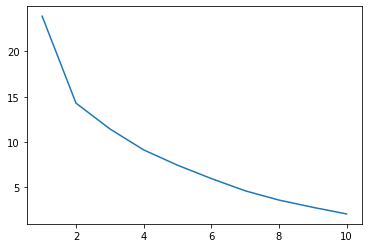

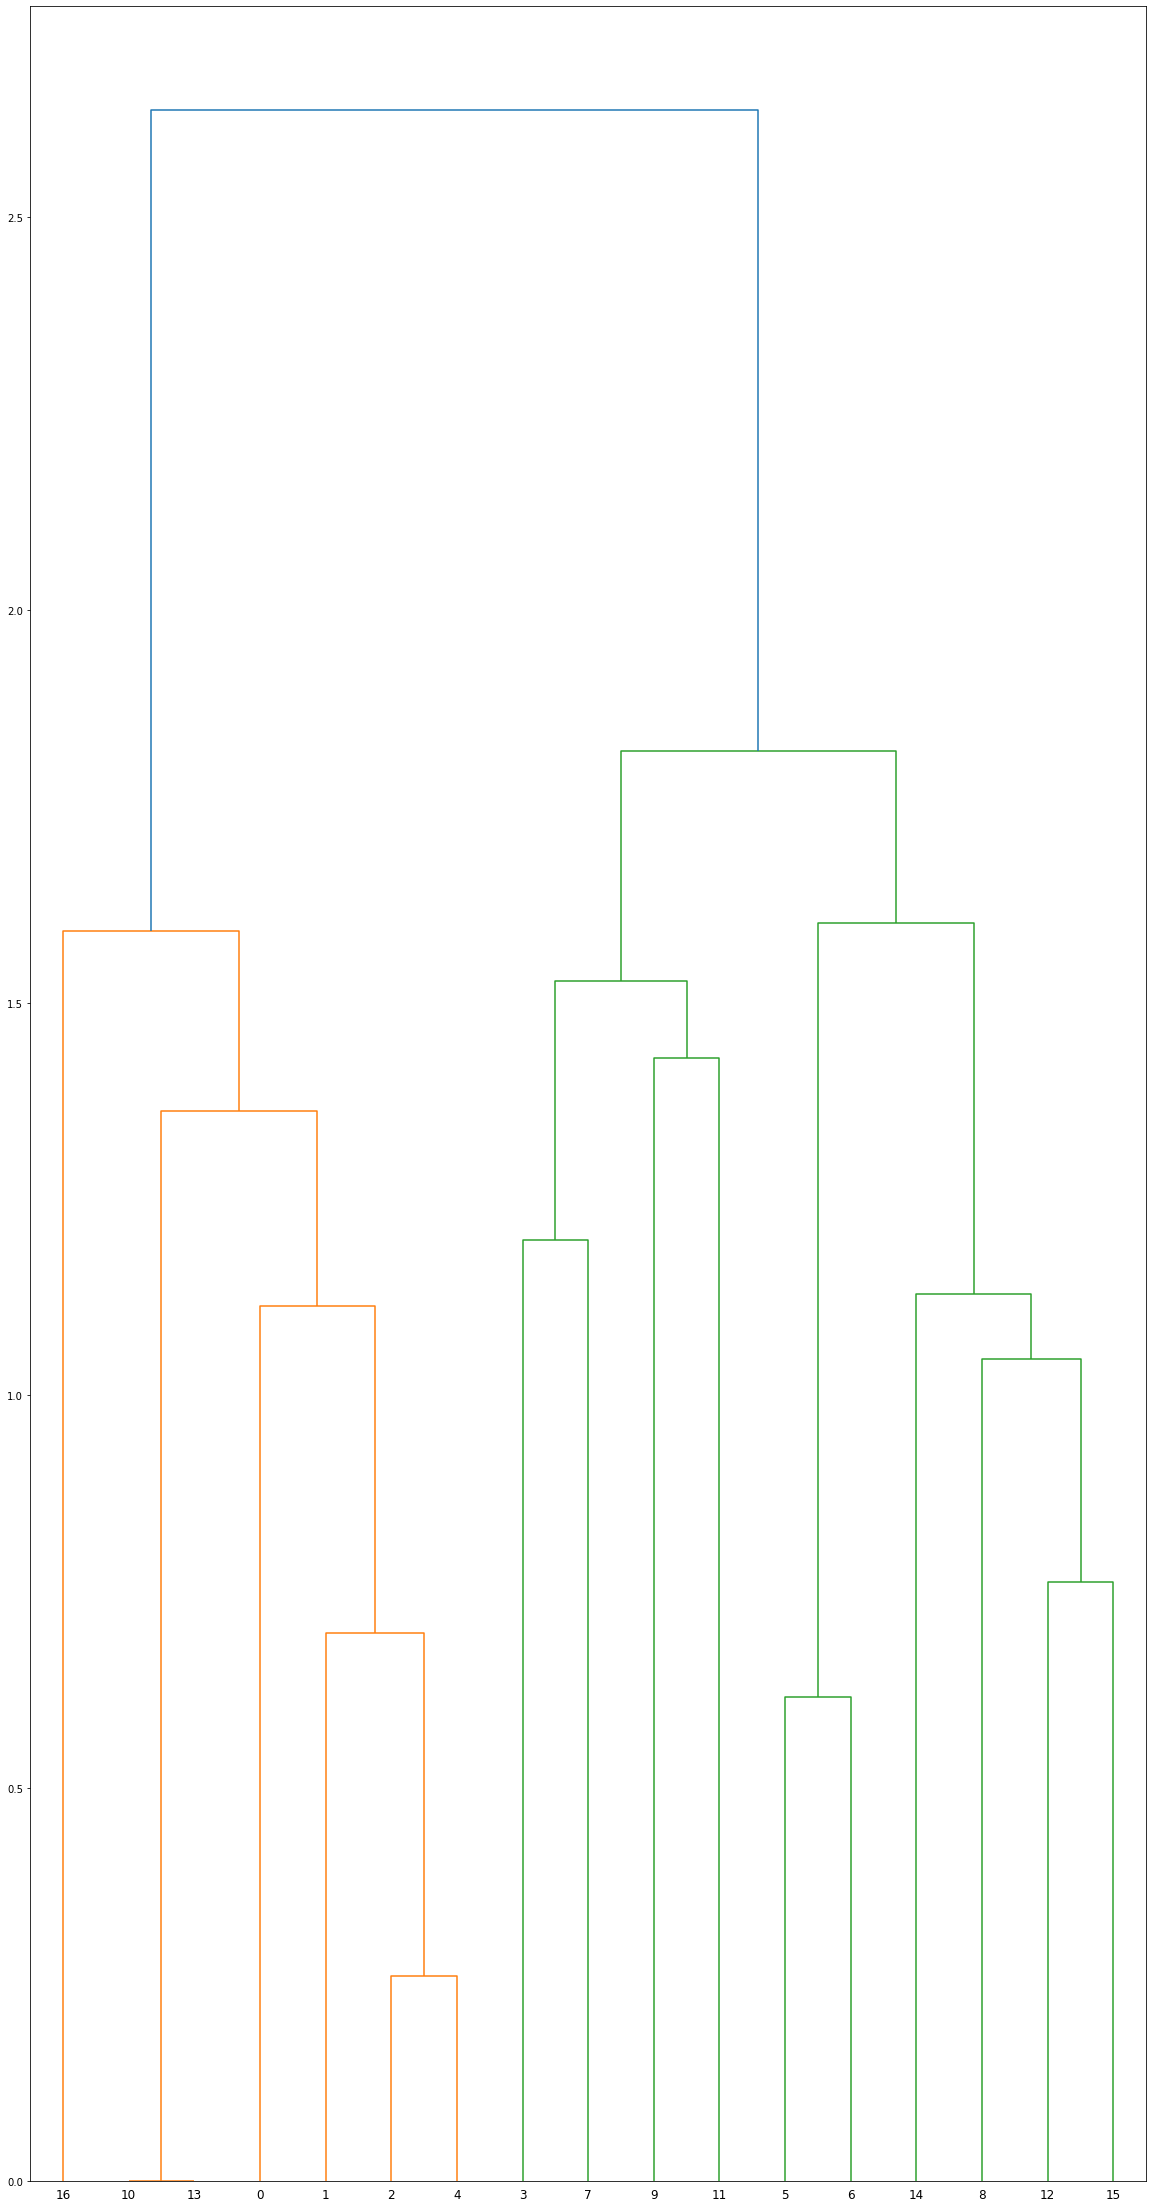

In [273]:
display_cor_clusters(data_df_csd)

In [263]:
# Input: 
# df: a scaled df, with columns [CODE, chosen_var_1, chosen_var_2, ... , chosen_var_n]
# num_intervals: the number of intervals to divide the data into (in our project we used 10)
# weights: a list of n weights for each of the variables 

# Output: 
# a dataframe with the original variables and the scores produced for each variable

# NOTES: This is information that needs to be saved in the mega-csv (or a separate csv file)

def create_score_table(df, num_intervals, weights):
    # This is some code for the scoring process
    # It creates a new dataframe for the scores of each variable
    # n is the number of itervals
    # num_vars is the number of variables used
    n = num_intervals
    num_vars = len(weights)
    meta_data = {}
    
    # calculate the interval size (max - min) / n
    for col in df.columns:
        if col == 'CODE':
            continue
        meta_data[col] = (df[col].max() - df[col].min()) / n

    # Create the score table
    score_df = df[['CODE']]
    score_list = []
    for keys in meta_data.keys():
        score_list.append('weighted_{}'.format(keys))
    score_df[score_list] = 0
    
    
    # iterate through and score each variable
    scoring = score_df.copy()
    for index, col in enumerate(df.columns):
        for i in range(n):
            if col == 'CODE':
                continue    
            if col != 'avg_income' and col != 'median_income':
                # Higher values mean higher scores
                scoring.loc[df[col].between(meta_data.get(col) * i, meta_data.get(col) * (i + 1)), 
                            ['weighted_{}'.format(col)]] = (i+1)
            else:
                # Higher values mean lower scores
                scoring.loc[df[col].between(meta_data.get(col) * i, meta_data.get(col) * (i + 1)), 
                            ['weighted_{}'.format(col)]] = num_intervals - i
                
    pre_scale = scoring[['weighted_{}'.format(keys) for keys in meta_data.keys()]].copy()
    pre_scale = pre_scale.set_axis(['unscaled_score_{}'.format(keys) for keys in meta_data.keys()], axis='columns', inplace=False)
    pre_scale['CODE'] = df['CODE']
    
    scoring = weights * scoring[['weighted_{}'.format(keys) for keys in meta_data.keys()]]
    scoring['total'] = scoring.sum(axis = 1)
    scoring['percent_total'] = scoring['total'] / num_vars
    scoring['CODE'] = df['CODE']
    # return_df = scoring.merge(df, left_on='CODE', right_on='CODE')
    return_df = scoring.merge(pre_scale, left_on='CODE', right_on='CODE')
    return_df = return_df.sort_values(by='total', ascending=False)
    return return_df

In [264]:
drop_list = [total_area, total_land_area, total_60_64, total_65_69, total_70_74, total_75_79, 
 total_80_84, total_85_plus, total_65_alone, house_pop_5_year_mobility,  movers, 
 household_tenure, rented, band_housing, total_condo_status, in_condo, rented_in_condo, 
 income_40_59, income_60_79, income_80_100, fifteen_older_income, without_income, 
 kids_home_10_14, total_10_14, lp_one_child, lp_two_child, lp_three_more_child, cf_with_children]

In [238]:
data_df_csd = scale_and_drop(CSD, drop_list)

In [239]:
data_df_csd

,CODE,total_pop_1_SCALAR,total_pop_2_SCALAR,total_5_9,total_fam_households_SCALAR,census_families_SCALAR,lone_parent,percent_children_home,total_kids_home_SCALAR,kids_home_5_9,...,vis_minority_total_SCALAR,vis_minority_blk,house_pop_abrgnl,abrgnl_id,pop_knowledge_off_lang_SCALAR,no_off_lang,household_recent_immigrant,total_recent_immigrant,unscaled_5_9,low_income
29477,5943816.0,237,237,0.071730,55,59,0.152542,56,80,0.212500,...,0,0.000000,3.246575,0.000000,237,0.000000,3.246575,0.000000,17,0.328767
29537,5943817.0,0,0,0.000000,0,0,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000
29597,5943835.0,10,10,0.200000,1,2,0.500000,100,3,0.000000,...,0,0.000000,10.000000,0.000000,10,0.000000,10.000000,0.000000,2,0.000000
29657,5943836.0,73,73,0.068493,0,0,0.000000,0,0,0.000000,...,0,0.000000,4.000000,0.000000,4,0.000000,4.000000,0.000000,5,0.000000
29717,5943837.0,461,461,0.047722,146,146,0.328767,33,162,0.135802,...,0,0.000000,1.822581,0.000000,452,0.000000,1.822581,0.000000,22,0.645161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72557,5915015.0,216320,216320,0.041841,57981,62174,0.165873,48,65889,0.131904,...,170221,0.009447,2.708127,0.011597,214443,0.111176,2.708127,0.061035,9051,0.257776
72588,5915020.0,19383,19383,0.045194,4156,4252,0.200611,42,4677,0.177892,...,12352,0.006477,2.526659,0.025502,17439,0.063249,2.526659,0.038745,876,0.393799
72619,5915022.0,682404,682404,0.033958,162731,171041,0.157477,29,153585,0.143868,...,369263,0.022799,2.197987,0.042352,668111,0.067013,2.197987,0.037324,23173,0.249262
72650,5915025.0,259715,259715,0.041700,65261,69153,0.161280,41,70224,0.148382,...,174255,0.027465,2.566490,0.028338,256726,0.069346,2.566490,0.057609,10830,0.259042


In [240]:
# display_cor_clusters(data_df_csd)

In [241]:
weights = [0.05, 0.05, 0.2, 0.1, 0.175, 0.1, 0.175, 0.15]
forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 'low_income', 'median_income', 'lone_parent', 'kids_home_5_9']
input_df = data_df_csd[['CODE'] + forced_choices]

In [242]:
table = create_score_table(input_df, 10, weights)

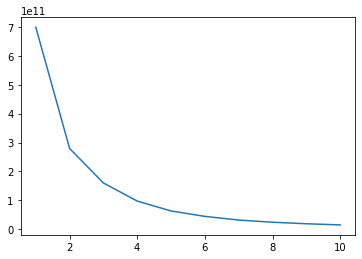

In [267]:
elbow(data_df_csd[forced_choices])

In [256]:
k_means(data_df_csd[forced_choices], data_df_csd['CODE'])
    

(737, 8)
(737,) (737,)
             var  cluster
29477  5943816.0        0
47921  5909844.0        0
42773  5933841.0        0
47981  5909845.0        0
42713  5933840.0        0
...          ...      ...
41878  5935018.0        1
41849  5905014.0        1
41818  5935016.0        1
41788  5903056.0        1
72680  5915029.0        1

[737 rows x 2 columns]
(737,) (737,)
             var  cluster
29477  5943816.0        0
47666  5903013.0        0
47677  5957803.0        0
42403  5909885.0        0
42343  5909884.0        0
...          ...      ...
40989  5941834.0        2
50231  5941856.0        2
50171  5941855.0        2
44248  5951804.0        2
48867  5919811.0        2

[737 rows x 2 columns]
(737,) (737,)
             var  cluster
43534  5924025.0        0
42871  5923035.0        0
42811  5923033.0        0
42751  5923025.0        0
42653  5933839.0        0
...          ...      ...
48161  5909849.0        3
45397  5909809.0        3
49991  5941851.0        3
47515  5933854.0 

In [134]:
# Input: file path to the boundary shape file with CSD and Da
# Ouput: A dataframe with two columns, one with CSDs and the other with the corresponding DA

def get_csd_da_conversion(shape_path):
    df_map= gpd.read_file('{}/lda_000a16a_e/lda_000a16a_e.shx'.format(shape_path))
    df_map_bc = df_map[df_map['PRNAME'] =='British Columbia / Colombie-Britannique'].reset_index(drop=True)
    return_df = df_map_bc[['DAUID', 'CSDUID', 'CSDNAME']]
    return return_df

In [135]:
# Input: file path to the postal code conversion file
# Output: A dataframe with postal codes, dissemination areas, csds, and 
# information relating to the quality of the data


def new_postal_da(pccf_path):
    postal_codes = []
    dissemination_areas = []
    csds = []
    quality = []
    retired = []
    sli = []
    rpt = []
    dmt = []
    lat = []
    lon = []
    bd = []
    source = []
    # Open the file
    with open(pccf_path, encoding = "ISO-8859-1") as file:
        # Iterate through the file line by line
        for line in file:
            # If province is BC
            if(line[9:11] == '59'):
                
                # Save the information of the line 
                postal_codes.append(line[0:6])
                dissemination_areas.append(line[125:133])
                csds.append(line[15:22])
                quality.append(line[212:215])
                retired.append(line[203:211])
                sli.append(line[161:162])
                rpt.append(line[136:137])
                dmt.append(line[193:194])
                lat.append(line[137: 148])
                lon.append(line[148: 162])
                bd.append(line[195:203])
                source.append(line[215:216])
                
    # Create a dataframe from the saved information 
    d = {'postal' : postal_codes, 'da' : dissemination_areas, 'csd' : csds, 'quality' : quality, 
         'retired' : retired, 'rpt' : rpt, 'dmt' : dmt,'bd' : bd, 'source' : source}  
    df1 = pd.DataFrame(data=d) 
    df2 = df1.drop_duplicates()
    
    # '19000001' refers to postal codes that are not expired
    df3 = df2[df2.retired == '19000001']
    
    # Return all the postal codes that have a quality higher than "No information"
    return df3[df3.quality != 'NNN']
    
    

In [136]:
new_postal_da(postal_da_path)

,postal,da,csd,quality,retired,rpt,dmt,bd,source
0,V0A0A0,59390219,5939007,BAA,19000001,1,W,20140601,1
15,V0A1H0,59390219,5939007,BAA,19000001,1,W,19830401,1
158,V0A1H3,59390218,5939007,BAA,19000001,1,W,20040701,1
208,V0A1H6,59390225,5939007,BAN,19000001,2,W,20040701,1
418,V0A1K4,59010132,5901039,BAA,19000001,1,W,19990701,1
...,...,...,...,...,...,...,...,...,...
226166,V9Z1N9,59170657,5917052,BAN,19000001,2,A,20180501,1
226168,V9Z1P1,59170668,5917052,BAA,19000001,1,A,20180501,1
226170,V9Z1P2,59170668,5917052,BAN,19000001,2,A,20190801,1
226172,V9Z1P5,59170664,5917052,BAB,19000001,1,A,20201101,1


In [137]:
def get_postal_da_conversion(pccf_path):
    
    postal_codes = []
    dissemination_areas = []

    with open(pccf_path, encoding = "ISO-8859-1") as file:
        counter = 0
        for line in file:
            if line[9:11] == '59':
                postal = line[0:6]
                formatted = " ".join(line.split())
                found = False
                start = 1
                arr = formatted.split()
                while not found and start < len(arr):
                    splitted = arr[start]
                    # print(splitted)
                    if len(splitted) < 35:
                        start += 1
                    else:
                        found = True


                da = "59" + splitted[len(splitted) - 10:len(splitted)-4]
                if counter < 10 and da == '59':
                    print(formatted)
                    counter += 1

                if postal == 'V6A4K3':
                    print(formatted)
                    print(arr)
                    print(splitted)
                    print(found)

                    # print(splitted[len(splitted)])
                if found:
                    postal_codes.append(postal)
                    dissemination_areas.append(da)
    d = {'postal' : postal_codes, 'da' : dissemination_areas}  
    df = pd.DataFrame(data=d) 
    
    removed_df = df[~df['postal'].duplicated(keep='first')]
    
    return removed_df

In [156]:
# Input: Paths to the schools out location, and schools out data
# Output: A dataframe with the list of locations split into separate rows and the data joined on

def so_locations(so_locations_path, so_data_path):
    in_dir1 = so_locations_path
    in_dir2 = so_data_path

    locations = pd.read_csv(in_dir1)
    locations=locations.dropna()
    data = pd.read_csv(in_dir2)
    
    # Split the list of postal codes
    locations["Postal Codes"] = locations["Postal Codes"].apply(split_fn)
    
    # Create a row for each postal code
    locations = locations.explode("Postal Codes")
    
    # Drop rows which have no postal codes
    locations = locations[locations["Postal Codes"] != "on Microsoft Teams and Zoom"]
    
    # Join the two tables based on the name of the program
    result = pd.merge(locations, data, how="left", on=["Unnamed: 0"])
    result = result.rename(columns={"Unnamed: 0": "Name"})
    return result

In [157]:
# Input: file paths to bc authorized childcare programs, schools out locations, 
# schools out data, postal code conversion, and boundary shape files
# Output: A dataframe with the DA, CSD, location name, and number of services for each area 
# Also prints the percentage of located services

def agency_table(bc_ccare_path, so_locations_path, so_data_path, pccf_path, shape_path):
    locations = pd.read_csv(bc_ccare_path)
    SO_locations = so_locations(so_locations_path, so_data_path)
    
    # Get the postal DA conversion
    postal = new_postal_da(pccf_path)
    postal['postal'] = postal['postal'].apply(add_space)
    
    # Format the schools out location postal codes
    SO_locations['Postal Codes']= SO_locations['Postal Codes'].str.replace('!','1',regex=True)
    SO_locations['Postal Codes'] = SO_locations['Postal Codes'].apply(add_space)
    SO_locations['Postal Codes'] = SO_locations['Postal Codes'].apply(to_upper)
    
    # Join the schools out table and postal code table on postal code
    new_df = SO_locations.merge(postal, left_on='Postal Codes', right_on='postal')
    
    # prints the percentage of located services
    print("Found: {}% of the Schools out locations".format(len(new_df) / len(SO_locations)))
    
    
    SO_postal_da = new_df[['postal', 'da', 'Agency Name']]
    SO_postal_da = SO_postal_da.rename(columns={'Agency Name' : 'NAME'})
    
    # Join the bc authorized locations with the postal DA conversion
    locations_postal_da = locations.merge(postal, left_on='POSTAL_CODE', right_on='postal')[['postal', 'da', 'NAME']]
    
    # prints the percentage of located services
    print("Found: {}% of the BC programs".format(len(locations_postal_da) / len(locations)))
    
    # Combine both tables together and drop duplicates
    combined_postal_da = pd.concat([SO_postal_da, locations_postal_da])
    combined_postal_da = combined_postal_da.drop_duplicates()
    
    # Get the CSD/DA conversion from the boundary shape file
    csd_da_con = get_csd_da_conversion(shape_path)
    csd_da_con['DAUID'] = csd_da_con['DAUID'].astype(str)
    
    # Join the CSD info on the combine table
    csd_info = combined_postal_da.merge(csd_da_con, left_on='da', right_on='DAUID')
    
    # Count the number of services in each CSD
    count_csd = csd_info.groupby('CSDUID').count()
    counted = csd_info.merge(count_csd['postal'], left_on='CSDUID', right_index = True).rename(columns={'postal_y': "num_childcare_services"})
    counted = counted[['DAUID', 'CSDUID', 'num_childcare_services', 'CSDNAME']]
    
    dropped = counted.drop_duplicates()
    
    return dropped

In [158]:
agency_table(bc_ccare_path, so_locations_path, 
             so_data_path, postal_da_path, shape_path)[['DAUID', 'CSDUID', 'num_childcare_services']]





Found: 0.7075471698113207% of the Schools out locations
Found: 0.6297658215598994% of the BC programs


,DAUID,CSDUID,num_childcare_services
0,59150115,5915046,95
3,59150071,5915046,95
259,59150136,5915046,95
275,59153573,5915046,95
336,59150252,5915046,95
...,...,...,...
2898,59010125,5901048,1
2913,59350270,5935801,1
2922,59170332,5917811,1
3035,59210470,5921014,1


In [141]:
# get_csd_da_conversion(shape_path)

In [142]:
# Input 

def score_supply(agent_table, con_table, agg_type):
    scored = agent_table.merge(con_table, how='right', right_on=agg_type, left_on=agg_type)
    
    print(agent_table, con_table)
    scored.replace([np.inf, -np.inf], np.nan, inplace=True)
    scored = scored.fillna(0)
    scored = scored.rename(columns={'CSDNAME_y' : 'CSDNAME'})
    # Should we include this part?
    if agg_type == 'CSDUID':
        scored = scored[['num_childcare_services', 'CSDUID', 'CSDNAME']]
        scored = scored.drop_duplicates()
    else:
        scored=scored.drop('CSDUID_x', axis=1)
        scored = scored.rename(columns={'CSDUID_y' : 'CSDUID'})
        
    print(scored)
    return scored
    

In [143]:
# NOTES: This is information that needs to be saved in the mega-csv (or a separate csv file)
# Input: the table of scores for each area, the geography to consider, number of intervals, and path to the 
# Environics data
# Output: A table with the supply scores for each area

def scale_score_supply(score_table, agg_type, intervals, environics_path):
    in_dir1 = environics_path
    data = pd.read_csv(in_dir1)
    
    if agg_type == 'DAUID':
        data = data[data.GEO == 'PRCDDA']
    else:
        data = data[data.GEO == 'PRCDCSD']
    
    data['CODE']=data['CODE'].astype(int)
    score_table[agg_type]=score_table[agg_type].astype(int)
    score_table = score_table[[agg_type, 'num_childcare_services', 'CSDNAME']]
        
    data = data.merge(score_table, left_on='CODE', right_on=agg_type)
    data['scaled_num_services'] = data['num_childcare_services'] / (data['ECYPTA_5_9'] + data['ECYPTA1014'])
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.fillna(0)
    
    
    data = data[[agg_type, 'num_childcare_services', 'scaled_num_services', 'CSDNAME']]
    
    n = intervals
    meta_data = {}
    meta_data['scaled_num_services'] = (data['scaled_num_services'].max() - data['scaled_num_services'].min()) / n
    data['supply_score'] = 0
    for i in range(n):
        data['supply_score'][data['scaled_num_services'].between(meta_data.get('scaled_num_services') * i, meta_data.get('scaled_num_services') * (i + 1))] = (i+1)
    
    data['supply_score'] /= 10
    
    return data

In [144]:
# NOTES: This is information that needs to be saved in the mega-csv (or a separate csv file)
# Input: Dataframes of supply scores, demand scores, agg_type = (DA, CSD), and boolean with_supply to compute
# need scores with or without considering supply
# Output: A Dataframe with the need scores for each area

def total_scores(supply, demand, agg_type, with_supply):
    supply[agg_type] = supply[agg_type].astype(int)
    demand['CODE'] = demand['CODE'].astype(int)
    full_data = demand.merge(supply, left_on='CODE', right_on=agg_type)
    if with_supply:
        full_data['diff'] = full_data['supply_score'] - full_data['percent_total']
    else:
        full_data['diff'] = 1 - full_data['percent_total']
    
    return full_data[['CODE', 'diff']]

In [145]:
def display_map(total_scores, agg_type, shape_path, col_name):
    if agg_type == 'CSDUID':
        mp = gpd.read_file('{}/lcsd000a16a_e/lcsd000a16a_e.shx'.format(shape_path))
    else:
        mp = gpd.read_file('{}/lda_000a16a_e/lda_000a16a_e.shx'.format(shape_path))
    mp = mp[mp['PRNAME'] =='British Columbia / Colombie-Britannique'].reset_index(drop=True)
    
    # mp = mp[mp['CDUID'] == '5909']
    
    # mp = mp.merge(total_scores, left_on='CSDUID', right_index = True)
    scores = total_scores[[col_name]]
    mp['scores'] = scores
    print(mp)
    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    mp.plot(column='scores', ax=ax, legend=True, cmap='OrRd')
    # plt.savefig('bc.png')
    # df_map5.show()
    plt.show()

In [146]:
def main(args):
    
    # Here is where we can change the variables and the weights
    
    if args == 'DA':
    
        weights = [0.2, 0.2, 0.2, 0.16, 0.12, 0.12]
        # weights = [1, 1, 1, 1, 1, 1]
        forced_choices = ['vis_minority_blk', 'house_pop_abrgnl', 'total_recent_immigrant', 'median_income', 'lone_parent', 'total_kids']
    else:
        
        # 0.13 * household_recent_immigrant, 0.13 * vis_minority_blk, 0.13 * abrgnl_id, 
        # 0.125 * no_off_lang, 0.125 * low_income, 0.125 * median_income, 0.1175 * lone_parent, 
        # 0.1175 * kids_home_5_9 
        # weights = [1, 1, 1, 1, 1, 1, 1, 1]
        
        # Paper submission version
        # weights = [0.13, 0.13, 0.13, 0.125, 0.125, 0.125, 0.1175, 0.1175]
        # forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 'low_income', 'median_income', 'lone_parent', 'total_kids_home']
        # Pronounced Weights Indigenous communities:
        weights = [0.05, 0.05, 0.2, 0.1, 0.175, 0.1, 0.175, 0.15]
        forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 'low_income', 'median_income', 'lone_parent', 'total_kids_home']
        

        # Without kids 10-14
        # forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 
        # 'low_income', 'median_income', 'lone_parent', 'kids_home_5_9'] 
        
        # Without poverty statistics
        # weights = [0.2, 0.2, 0.2, 0.16, 0.12, 0.12]
        # forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 'lone_parent', 'total_kids_home']

        # Without aboriginal community 
        # weights = [0.195, 0.195, 0.125, 0.125, 0.125, 0.1175, 0.1175]
        # forced_choices = ['household_recent_immigrant', 'vis_minority_blk', 'no_off_lang', 'low_income', 'median_income', 'lone_parent', 'total_kids_home']
        
        # With kids 10-14
        # forced_choices = ['household_recent_immigrant', 'abrgnl_id', 'vis_minority_blk', 'no_off_lang', 'median_income', 'low_income', 'lone_parent', 'total_kids_home']

        
    
    bc_ccare_path = '402DATA/childcare_locations.csv'
    environics_path = "402DATA/SFU_CommunityImpactSO/EnvironicsData/DemoStats_2020_SelectVarsData.csv"
    so_locations_path = "402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_map.csv"
    so_data_path = "402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_DirectMetrics.csv"
    pccf_path = '402DATA/dataverse_files/Data/pccfNat_fccpNat_082021.txt'
    shape_path = '402DATA/SFU_CommunityImpactSO/GeoData/BoundaryShapeFiles'
    
    interval_num = 10
    num_vars = len(weights)
    
    if args == 'DA':
        pr_code = 'PRCDDA'
        agg_type = 'DAUID'
    elif args == 'CSD':
        pr_code = 'PRCDCSD'
        agg_type = 'CSDUID'
        
    df1 = pd.read_csv(environics_path)

    
    drop_list = [total_area, total_land_area, total_60_64, total_65_69, total_70_74, total_75_79, 
                 total_80_84, total_85_plus, total_65_alone, house_pop_5_year_mobility,  movers, 
                 household_tenure, rented, band_housing, total_condo_status, in_condo, rented_in_condo, 
                 income_40_59, income_60_79, income_80_100, fifteen_older_income, without_income, 
                 kids_home_10_14, total_10_14, lp_one_child, lp_two_child, lp_three_more_child]
    
    df = rename(scale_and_drop(get_rows(df1, pr_code), drop_list))
    df_choice = df[['CODE'] + forced_choices]
    
    demand = create_score_table(df_choice, num_vars, interval_num, weights)
    
    print(demand.sort_values(by='total').head(20))
    print()
    
    counted = agency_table(bc_ccare_path, so_locations_path, so_data_path, pccf_path, shape_path)
    csd_da = get_csd_da_conversion(shape_path)
    score_table = score_supply(counted, csd_da, agg_type)
    supply = scale_score_supply(score_table, agg_type, interval_num, environics_path)
    
    with_supply = True
    totals = total_scores(supply, demand, agg_type, with_supply)
    
    minimum = totals['diff'].min()
    maximum = totals['diff'].max()
    totals['diff'] = totals['diff'].apply(normalize, args=(maximum, minimum,))
    
    
    # totals['total'][totals['total_kids_home'] == 0] = 0
    
#     totals['CODE'] = totals['CODE'].astype(int)
#     csd_da['DAUID'] = csd_da['DAUID'].astype(int)
    
#     totals['diff'][totals['diff'] >= 0.90] = 1

    
#     totals = totals.merge(csd_da, left_on='CODE', right_on='DAUID')
#     totals = totals[['diff', 'CSDUID', 'total_kids']]
#     totals = totals.groupby('CSDUID').median()
    
    totals['diff'][totals['total_kids_home'] == 0] = 0
    print(totals)
    display_map(totals, 'CSDUID', shape_path, 'diff')

    
    print("printing diff")

    sorted_totals = totals.sort_values(by='diff', ascending=False)
    print(sorted_totals[['diff', 'CSDUID']].head(20))
    # print(sorted_totals[sorted_totals['diff'] == 1])
    
    # print("printing totals")
    # sorted_totals = totals.sort_values(by='total', ascending=False)
    # print(sorted_totals.head(20))
    
    return sorted_totals

In [147]:
# totals = main('CSD')

In [148]:
# from bs4 import BeautifulSoup
# from requests_html import HTMLSession
# from pprint import pprint

In [149]:
# # initialize an HTTP session
# session = HTMLSession()

In [150]:
# def get_all_forms(url):
#     """Returns all form tags found on a web page's `url` """
#     # GET request
#     res = session.get(url)
#     # for javascript driven website
#     res.html.render()
#     soup = BeautifulSoup(res.html.html, "html.parser")
#     return soup.find_all("div")


In [151]:
# get_all_forms('https://www12.statcan.gc.ca/census-recensement/2016/geo/geosearch-georecherche/index-eng.cfm')

In [152]:
# import requests

# url = 'https://www12.statcan.gc.ca/census-recensement/2016/geo/geosearch-georecherche/index-eng.cfm'
# myobj = {'dijitReset dijitInputInner': 'V0N2H1'}

# x = requests.post(url, json = myobj)

# print(x.text)

In [153]:
bc_ccare_path = "~/Desktop/code/Math402W/402DATA/childcare_locations.csv"
environics_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/EnvironicsData/DemoStats_2020_SelectVarsData.csv"
so_locations_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_map.csv"
so_data_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/SchoolsOutData/SO_DirectMetrics.csv"
shape_path = "~/Desktop/code/Math402W/402DATA/SFU_CommunityImpactSO/GeoData/BoundaryShapeFiles"
postal_da_path = r"/Users/evanvulliamy/Desktop/code/Math402W/402DATA/dataverse_files/Data/pccfNat_fccpNat_082021.txt"

In [154]:
def new_main(bc_ccare_path, environics_path, so_locations_path, so_data_path, shape_path, postal_da_path):
    
    # Change args to be input into new_main
    args = 'CSD'
    interval_num = 10

    if args == 'DA':
        pr_code = 'PRCDDA'
        agg_type = 'DAUID'
    elif args == 'CSD':
        pr_code = 'PRCDCSD'
        agg_type = 'CSDUID'
    
    # Create the dataframes based on the paths

    bc_ccare_df = pd.read_csv(bc_ccare_path)
    environics_df = pd.read_csv(environics_path)
    so_locations_df = pd.read_csv(so_locations_path)
    so_data_df = pd.read_csv(so_data_path)
    
    # Get correct rows (province and geographic region)
    
    CSD = get_rows(environics_df, "PRCDCSD") # PRCDDA for dissemination areas    
    
    # List of variables that can be dropped 
    drop_list = [total_area, total_land_area, total_60_64, total_65_69, total_70_74, total_75_79, 
     total_80_84, total_85_plus, total_65_alone, house_pop_5_year_mobility,  movers, 
     household_tenure, rented, band_housing, total_condo_status, in_condo, rented_in_condo, 
     income_40_59, income_60_79, income_80_100, fifteen_older_income, without_income, 
     kids_home_10_14, total_10_14, lp_one_child, lp_two_child, lp_three_more_child, cf_with_children]
    
    # Scale the variables and drop variables in drop_list
    data_df_csd = scale_and_drop(CSD, drop_list)
    
    # ADD CODE TO SAVE CLUSTERS AS CSV
    # Should variable selection and scoring be two separate branches?
    
    display_cor_clusters(data_df_csd)
    
    
    # Chose weights and variables based on corelation clusters
    weights = [0.05, 0.05, 0.2, 0.1, 0.175, 0.1, 0.175, 0.15]
    choices = ['household_recent_immigrant', 'vis_minority_blk', 'abrgnl_id', 'no_off_lang', 'low_income', 'median_income', 'lone_parent', 'kids_home_5_9']
    input_df = data_df_csd[['CODE'] + choices]
    
    # Create demand scores
    table = create_score_table(input_df, 10, weights)
    merged_table = table.merge(data_df_csd, on='CODE')
    
    # Create table for different childcare locations
    counted = agency_table(bc_ccare_path, so_locations_path, so_data_path, postal_da_path, shape_path)
    # Create table to link csd to da
    csd_da = get_csd_da_conversion(shape_path)
    
    # Create supply scores
    score_table = score_supply(counted, csd_da, agg_type)
    supply = scale_score_supply(score_table, agg_type, interval_num, environics_path)
    merged_table = supply.merge(merged_table, left_on='CSDUID', right_on = 'CODE')
    
    # Create total scores
    with_supply = True
    totals = total_scores(supply, table, agg_type, with_supply)
    merged_table = totals.merge(merged_table, on = 'CODE')
    
    # Apply Normalization
    minimum = totals['diff'].min()
    maximum = totals['diff'].max()
    merged_table['normalized'] = merged_table['diff'].apply(normalize, args=(maximum, minimum,))
    
    # When should we set no kids to 0?
    # merged_table['normalized'][merged_table['total_kids_home'] == 0] = 0
    
    merged_table = merged_table.drop('CSDUID', axis = 1)
    
    merged_table['is_num'] = merged_table['CSDNAME'].apply(get_last_word)
    
    
    # Order the columns
    
    code = ['CODE', 'CSDNAME', 'is_num']
    scalars = []
    unused_vars = []
    unscaled_scores = []
    weighted_scores = []
    total_need = ['total', 'percent_total']
    supply = ['num_childcare_services', 'scaled_num_services', 'supply_score']
    results = ['diff', 'normalized']
    
    for col in merged_table.columns:
        if 'SCALAR' in col:
            scalars.append(col)
        
        if 'unscaled' in col and col != 'unscaled_5_9':
            unscaled_scores.append(col)
            
        if 'weighted' in col:
            weighted_scores.append(col)
                
    for col in data_df_csd.columns:
        if col not in scalars and col not in choices and col != 'CODE':
            unused_vars.append(col)
            
    merged_table[code + scalars + unused_vars + choices + unscaled_scores 
                       + weighted_scores + total_need + supply + results][merged_table.is_num == True].to_csv('test.csv', index=False)
    
    merged_table[code + scalars + unused_vars + choices + unscaled_scores 
                       + weighted_scores + total_need + supply + results].to_csv('full_data.csv', index=False)
    

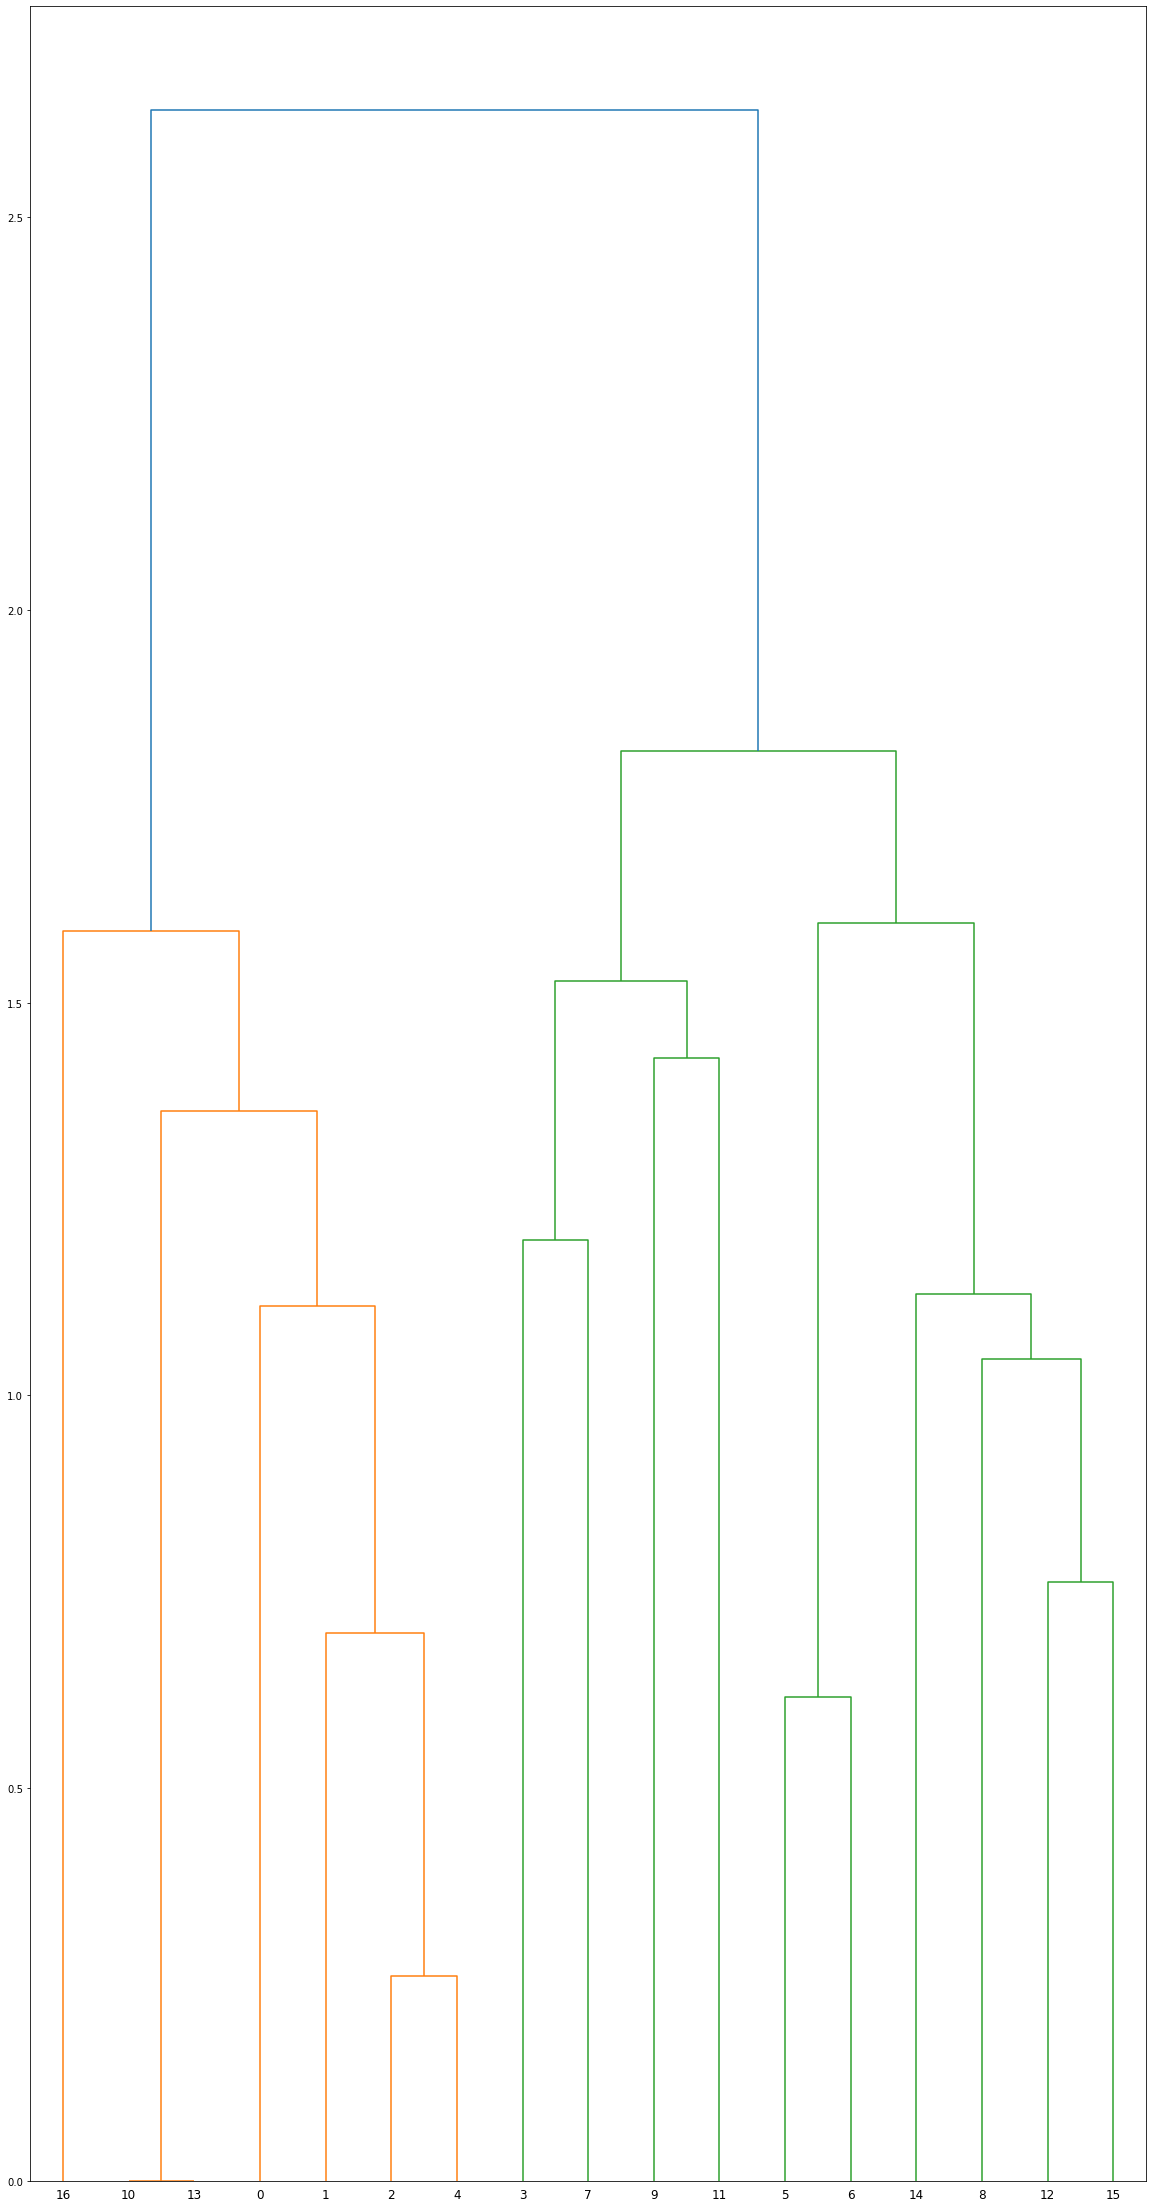

                           var  cluster
13  household_recent_immigrant        1
10            house_pop_abrgnl        1
0                    total_5_9        2
1                  lone_parent        2
2        percent_children_home        2
4            avg_child_per_fam        2
16                  low_income        3
7            unemployment_rate        4
3                kids_home_5_9        4
9             vis_minority_blk        5
11                   abrgnl_id        6
5                median_income        7
6                   avg_income        7
15                unscaled_5_9        8
12                 no_off_lang        8
14      total_recent_immigrant        8
8       travel_to_work_transit        8
Found: 0.7075471698113207% of the Schools out locations
Found: 0.6297658215598994% of the BC programs
         DAUID   CSDUID  num_childcare_services          CSDNAME
0     59150115  5915046                      95  North Vancouver
3     59150071  5915046                      95 

In [155]:
new_main(bc_ccare_path, environics_path, so_locations_path, so_data_path, shape_path, postal_da_path)